In [1]:
import os

os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"

## Analyze whether early or late snow changes more year to year or place to place.

* We know from previous notebooks that the value of `coef_2` corresponds to whether the snow season is early or late. 
* We want to study whether early/late season is more dependent on the year or on the location.
* We will use RMS Error to quantify the strength of these dependencies.

In [2]:
import pandas as pd
import numpy as np
import urllib
import math

In [3]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
%pylab inline
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [5]:
### Read the data frame from pickle file

data_dir='./Data/Weather'
state='WA'
meas='PRCP_s20'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [6]:
#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())


15972


In [7]:
tmp=df.filter(df.Station=='USC00306411').toPandas()
tmp.head(1)

,Measurement,Station,Values,Year,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,dist_coast,...,latitude,longitude,name,res_1,res_2,res_3,res_4,res_5,res_mean,total_var


In [8]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Features='station, year, coeff_2'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM weather


,station,year,coeff_2
0,USC00457015,1944,44.395188
1,USC00457015,1945,20.058190
2,USC00457015,1946,31.412405
3,USC00457015,1947,-36.317653
4,USC00457015,1948,57.979273


In [9]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(5)

station,USC00450008,USC00450013,USC00450094,USC00450158,USC00450176,USC00450184,USC00450217,USC00450257,USC00450456,USC00450482,...,USW00024244,USW00024255,USW00024281,USW00094103,USW00094197,USW00094225,USW00094227,USW00094239,USW00094240,USW00094290
year,,,,,,,,,,,,,,,,,,,,,
2009,-262.966774,NaN,NaN,NaN,-98.483033,NaN,-65.775733,-88.173272,-159.312380,-67.913973,...,NaN,-9.554030,NaN,NaN,-20.372479,-237.975710,-213.643980,10.837175,-440.161400,-112.095554
2010,-134.685734,NaN,NaN,NaN,-97.027176,NaN,269.101428,-77.072960,-382.706305,-112.922240,...,NaN,-32.145490,NaN,NaN,61.272779,-81.946805,-102.743661,5.492696,-104.067155,-77.793182
2011,275.984982,NaN,NaN,NaN,114.628919,NaN,NaN,156.070765,242.958390,134.755807,...,NaN,62.122944,NaN,NaN,36.674867,234.883303,4.754243,39.998595,245.338372,91.871640
2012,-245.088130,NaN,NaN,NaN,57.611072,NaN,NaN,-92.668876,-54.614701,8.942175,...,NaN,3.261617,NaN,NaN,-29.308119,-218.376002,-172.379279,-2.558291,9.599859,-138.189794
2013,564.490641,NaN,NaN,NaN,NaN,NaN,NaN,576.400197,345.484464,49.144106,...,NaN,99.937858,NaN,NaN,89.579481,589.370257,420.255159,48.857641,770.581736,248.821581


Text(0,0.5,'Number of stations')

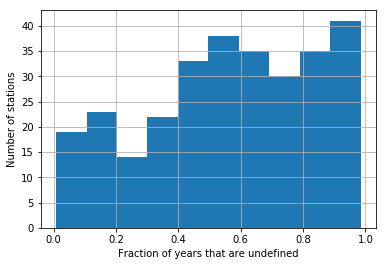

In [10]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

Text(0,0.5,'fraction of stations that are undefined')

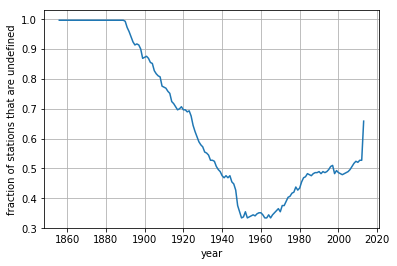

In [11]:
year_nulls=pd.isnull(year_station_table).mean(axis=1)
year_nulls.plot();
grid()
ylabel('fraction of stations that are undefined')

In [12]:
pdf2=pdf[pdf['year']>1960]
year_station_table=pdf2.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(5)

station,USC00450008,USC00450013,USC00450158,USC00450176,USC00450184,USC00450217,USC00450257,USC00450456,USC00450482,USC00450564,...,USW00024244,USW00024255,USW00024281,USW00094103,USW00094197,USW00094225,USW00094227,USW00094239,USW00094240,USW00094290
year,,,,,,,,,,,,,,,,,,,,,
2009,-262.966774,NaN,NaN,-98.483033,NaN,-65.775733,-88.173272,-159.312380,-67.913973,NaN,...,NaN,-9.554030,NaN,NaN,-20.372479,-237.975710,-213.643980,10.837175,-440.161400,-112.095554
2010,-134.685734,NaN,NaN,-97.027176,NaN,269.101428,-77.072960,-382.706305,-112.922240,NaN,...,NaN,-32.145490,NaN,NaN,61.272779,-81.946805,-102.743661,5.492696,-104.067155,-77.793182
2011,275.984982,NaN,NaN,114.628919,NaN,NaN,156.070765,242.958390,134.755807,NaN,...,NaN,62.122944,NaN,NaN,36.674867,234.883303,4.754243,39.998595,245.338372,91.871640
2012,-245.088130,NaN,NaN,57.611072,NaN,NaN,-92.668876,-54.614701,8.942175,NaN,...,NaN,3.261617,NaN,NaN,-29.308119,-218.376002,-172.379279,-2.558291,9.599859,-138.189794
2013,564.490641,NaN,NaN,NaN,NaN,NaN,576.400197,345.484464,49.144106,NaN,...,NaN,99.937858,NaN,NaN,89.579481,589.370257,420.255159,48.857641,770.581736,248.821581


Text(0,0.5,'Number of stations')

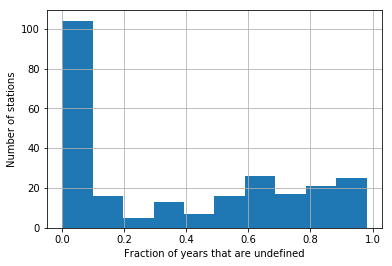

In [13]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the second eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [14]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print('total RMS                   = ',RMS(year_station_table))
print('RMS removing mean-by-station= ',RMS(tbl_minus_station),'reduction=',RMS(year_station_table)-RMS(tbl_minus_station))
print('RMS removing mean-by-year   = ',RMS(tbl_minus_year),'reduction=',RMS(year_station_table)-RMS(tbl_minus_year))

total RMS                   =  193.97808938254104
RMS removing mean-by-station=  192.5958016159168 reduction= 1.3822877666242448
RMS removing mean-by-year   =  173.10511150753257 reduction= 20.872977875008473


### Conclusion Of Analysis
The effect of time is about four times as large as the effect of location.

### Iterative reduction
* After removing one component, the other component can have an effect.
* We can use **alternating minimization** to remove the combined effect of location and time.

In [15]:
T=year_station_table
print('initial RMS=',RMS(T))
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print(i,'after removing mean by year    =',RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print(i,'after removing mean by stations=',RMS(T))

initial RMS= 193.97808938254104
0 after removing mean by year    = 173.10511150753257
0 after removing mean by stations= 171.59698732163318
1 after removing mean by year    = 171.56551975699904
1 after removing mean by stations= 171.55857652507788
2 after removing mean by year    = 171.55693212145212
2 after removing mean by stations= 171.55653687595105
3 after removing mean by year    = 171.55644145174702
3 after removing mean by stations= 171.5564183796892
4 after removing mean by year    = 171.55641279842777
4 after removing mean by stations= 171.55641144805017


In [16]:
T['mean_by_year']=mean_by_year
T['mean_by_year'].head()

year
1961   -0.084451
1962   -0.079266
1963   -0.075557
1964   -0.071394
1965   -0.066778
Name: mean_by_year, dtype: float64

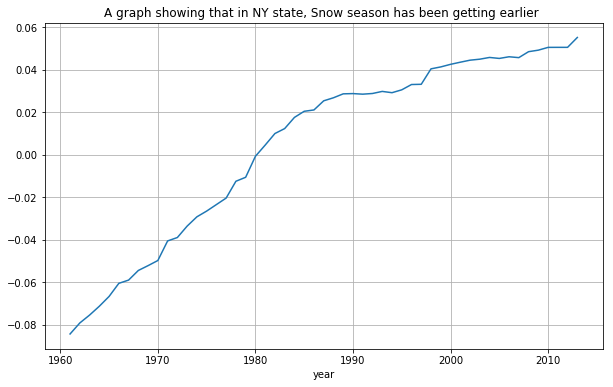

In [17]:
figure(figsize=(10,6))
T['mean_by_year'].plot();
grid()
title('A graph showing that in NY state, Snow season has been getting earlier ');

## Summary
* The problem of missing data is prevalent and needs to be addressed.
* RMS can be used to quantify the effect of different factors (here, time vs. space)
* The snow season in NY has been getting earlier and earlier since 1960.